In [1]:
import os  
import pickle 
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!!!')

cuda is available!!!


In [2]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(64, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU()
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

In [3]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
        
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
batch_size = 128
lr = 0.0002
z_dim = 64
num_epochs = 25
sample_num = 16
log_dir = './logs'

In [6]:
G = Generator()
D = Discriminator()
if cuda:
    G.cuda()
    D.cuda()

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
def train(D, G, criterion, D_optimizer, G_optimizer, data_loader):
    D.train()
    G.train()
    
    #本物のラベルは1
    y_real = Variable(torch.ones(batch_size, 1))
    #偽物のラベルは0
    y_fake = Variable(torch.zeros(batch_size, 1))
    if cuda:
        y_real = y_real.cuda()
        y_fake = y_fake.cuda()
    
    D_running_loss = 0
    G_running_loss = 0
    for batch_idx, (real_images, _) in enumerate(data_loader):
        #一番最後、バッチサイズに満たない場合は無視する
        if real_images.size()[0] != batch_size:
            break
        
        z = torch.rand((batch_size, z_dim))
        if cuda:
            real_images, z = real_images.cuda(), z.cuda()
        real_images, z = Variable(real_images), Variable(z)
        
        #Discriminatorの更新
        D_optimizer.zero_grad()
        
        #Discriminatorにとって本物画像の認識結果は1に近いほどよい
        D_real = D(real_images)
        D_real_loss = criterion(D_real, y_real)
        
        #DiscrimitorにとってGeneratorが生成した偽物画像の認識結果は0(偽物)に近いほどよい
        # E[log(1 - D(G(z)))]
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()してとめる
        fake_images = G(z)
        D_fake = D(fake_images.detach())
        D_fake_loss = criterion(D_fake, y_fake)
        
        #2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.data[0]
        
        #Generatorの更新
        G_optimizer.zero_grad()
        
        #GeneratorにとってGeneratorの画像が生成した画像の認識結果が1に近いほどよい
        #E[log(D(G(z)))]
        fake_images = G(z)
        D_fake = D(fake_images)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.data[0]
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss

In [9]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # 生成のもとになる乱数を生成
    sample_z = torch.rand((64, z_dim))
    if cuda:
        sample_z = sample_z.cuda()
    sample_z = Variable(sample_z, volatile=True)
    
    # Generatorでサンプル生成
    samples = G(sample_z).data.cpu()
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [10]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

# 学習履歴を保存
with open(os.path.join(log_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)


/home/nakamura-t/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/nakamura-t/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch 1, D_loss: 0.7929 G_loss: 1.3308


/home/nakamura-t/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


epoch 2, D_loss: 0.8734 G_loss: 1.3232
epoch 3, D_loss: 0.9083 G_loss: 1.2748
epoch 4, D_loss: 0.9001 G_loss: 1.3097
epoch 5, D_loss: 0.8885 G_loss: 1.3446
epoch 6, D_loss: 0.8719 G_loss: 1.3854
epoch 7, D_loss: 0.8603 G_loss: 1.4156
epoch 8, D_loss: 0.8335 G_loss: 1.4664
epoch 9, D_loss: 0.8304 G_loss: 1.4932
epoch 10, D_loss: 0.7930 G_loss: 1.5485
epoch 11, D_loss: 0.7754 G_loss: 1.5911
epoch 12, D_loss: 0.7490 G_loss: 1.6517
epoch 13, D_loss: 0.7458 G_loss: 1.6954
epoch 14, D_loss: 0.7220 G_loss: 1.7374
epoch 15, D_loss: 0.6937 G_loss: 1.7836
epoch 16, D_loss: 0.6796 G_loss: 1.8451
epoch 17, D_loss: 0.6651 G_loss: 1.8963
epoch 18, D_loss: 0.6386 G_loss: 1.9395
epoch 19, D_loss: 0.6282 G_loss: 1.9944
epoch 20, D_loss: 0.6083 G_loss: 2.0368
epoch 21, D_loss: 0.5946 G_loss: 2.0860
epoch 22, D_loss: 0.5717 G_loss: 2.1492
epoch 23, D_loss: 0.5751 G_loss: 2.1707
epoch 24, D_loss: 0.5753 G_loss: 2.1931
epoch 25, D_loss: 0.5495 G_loss: 2.2532


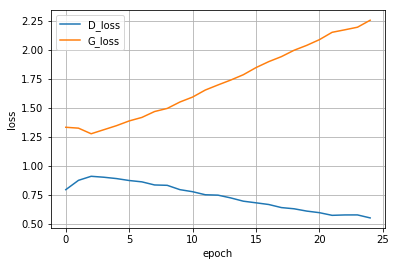

In [11]:
with open(os.path.join(log_dir, 'history.pkl'), 'rb') as f:
    history = pickle.load(f)

D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
